# PS4-6: Reinforcement Learning: The inverted pendulum

## Import Library

In [169]:
from __future__ import division, print_function
from src.env import CartPole, Physics
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter

## Training RL Model

### Training Algorithm

In [170]:
def initialize_mdp_data(num_states):
    """
    Return a variable that contains all the parameters/state you need for your MDP.
    Feel free to use whatever data type is most convenient for you (custom classes, tuples, dicts, etc)

    Assume that no transitions or rewards have been observed.
    Initialize the value function array to small random values (0 to 0.10, say).
    Initialize the transition probabilities uniformly (ie, probability of
        transitioning for state x to state y using action a is exactly
        1/num_states).
    Initialize all state rewards to zero.

    Args:
        num_states: The number of states

    Returns: The initial MDP parameters
    """
    transition_counts = np.zeros((num_states, num_states, 2))               # 3D array: (s, s', a)
    transition_probs = np.ones((num_states, num_states, 2)) / num_states    # 3D array: (s, s', a)
    # Index zero is count of rewards being -1 , index 1 is count of total num state is reached
    reward_counts = np.zeros((num_states, 2))           # 2D array: (s, a)
    reward = np.zeros(num_states)                       # 1D array: (s,)
    value = np.random.rand(num_states) * 0.1            # 1D array: (s,)

    return {
        'transition_counts': transition_counts,
        'transition_probs': transition_probs,
        'reward_counts': reward_counts,
        'reward': reward,
        'value': value,
        'num_states': num_states,
    }

In [171]:
def choose_action(state, mdp_data):
    """
    Choose the next action (0 or 1) that is optimal according to your current
    mdp_data. When there is no optimal action, return a random action.

    Args:
        state: The current state in the MDP
        mdp_data: The parameters for your MDP. See initialize_mdp_data.

    Returns:
        0 or 1 that is optimal according to your current MDP
    """

    # *** START CODE HERE ***

    # 1. Initialize Current Parameters at State s
    transition_probs = mdp_data['transition_probs']
    value = mdp_data['value']
    num_states = mdp_data['num_states']
    num_actions = 2         # Because we only have 2 action: 0 or 1

    # 2. Calculate V(s) for each action
    #V(s) = ∑(s'∈S) Psa(s')*V(s')
    action_value = np.zeros(num_actions)
    for a in range(num_actions):
        for s_next in range(num_states):
            action_value[a] += transition_probs[state, s_next, a] * value[s_next]

    # 3. Get Optimal Value Action V*(s) & Choose Optimal Action a*
    #V*(s) = max_(a∈A)(V(s)) => a* = argMax(a∈A)(V(s))
    optimal_value = -1e9
    optimal_action = 0
    cnt = 0

    for a in range(num_actions):
        if optimal_value < action_value[a]:
            optimal_value = action_value[a]
            optimal_action = a
            cnt = 1
        elif optimal_value == action_value[a]:
            cnt += 1

    # 4. If no optimal action, return a random action
    if cnt > 1:
        actions = [0, 1]
        optimal_action = np.random.choice(actions)

    return optimal_action
    # *** END CODE HERE ***

In [172]:
def update_mdp_transition_counts_reward_counts(mdp_data, state, action, new_state, reward):
    """
    Update the transition count and reward count information in your mdp_data.
    Do not change the other MDP parameters (those get changed later).

    Record the number of times `state, action, new_state` occurs.
    Record the rewards for every `new_state`
    (since rewards are -1 or 0, you just need to record number of times reward -1 is seen in 'reward_counts' index new_state,0)
    Record the number of time `new_state` was reached (in 'reward_counts' index new_state,1)

    Args:
        mdp_data: The parameters of your MDP. See initialize_mdp_data.
        state: The state that was observed at the start.
        action: The action you performed.
        new_state: The state after your action.
        reward: The reward after your action (i.e. reward corresponding to new_state).

    Returns:
        Nothing
    """

    # *** START CODE HERE ***
    # 1. Get All Current Parameters at State s
    transition_counts = mdp_data['transition_counts']
    reward_counts = mdp_data['reward_counts']

    # 2. Update transition_counts
    transition_counts[state, new_state, action] += 1

    # 3. Update reward_counts
    if reward == -1:
        reward_counts[new_state, 0] += 1

    reward_counts[new_state, 1] += 1
    # *** END CODE HERE ***

    # This function does not return anything
    return

In [173]:
def update_mdp_transition_probs_reward(mdp_data):
    """
    Update the estimated transition probabilities and reward values in your MDP.

    Make sure you account for the case when a state-action pair has never
    been tried before, or the state has never been visited before. In that
    case, you must not change that component (and thus keep it at the
    initialized uniform distribution).

    Args:
        mdp_data: The data for your MDP. See initialize_mdp_data.

    Returns:
        Nothing

    """

    # *** START CODE HERE ***
    # 1. Get All Current Parameters at State s
    transition_counts = mdp_data['transition_counts']
    transition_probs = mdp_data['transition_probs']
    reward_counts = mdp_data['reward_counts']
    reward = mdp_data['reward']
    num_states = mdp_data['num_states']
    num_actions = 2         # Because we only have 2 action: 0 or 1

    # 2. Update reward R(s)
    for s in range(num_states):
        if reward_counts[s, 1] > 0:
            reward[s] = -1 * reward_counts[s, 0] / reward_counts[s, 1]

    # 3. Update transition_probs Psa(s')
    for s in range(num_states):
        for a in range(num_actions):
            total = 0
            for s_next in range(num_states):
                total += transition_counts[s, s_next, a]

            if total > 0:
                #update transition_probs
                for s_next in range(num_states):
                    transition_probs[s, s_next, a] = transition_counts[s, s_next, a] / total

    # 4. Save back
    mdp_data['reward'] = reward
    mdp_data['transition_probs'] = transition_probs
    # *** END CODE HERE ***

    # This function does not return anything
    return

In [174]:
def update_mdp_value(mdp_data, tolerance, gamma):
    """
    Update the estimated values in your MDP.

    Perform value iteration using the new estimated model for the MDP.
    The convergence criterion should be based on `TOLERANCE` as described
    at the top of the file.

    Return true if it converges within one iteration.

    Args:
        mdp_data: The data for your MDP. See initialize_mdp_data.
        tolerance: The tolerance to use for the convergence criterion.
        gamma: Your discount factor.

    Returns:
        True if the value iteration converged in one iteration

    """

    # *** START CODE HERE ***

    # 1. Get All Current Parameters in State s
    transition_probs = mdp_data['transition_probs']
    reward = mdp_data['reward']
    value = mdp_data['value']
    num_states = mdp_data['num_states']
    num_actions = 2

    # 2. Update MDP
    old_value = value.copy()

    for s in range(num_states):
        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            for s_next in range(num_states):
                action_values[a] += transition_probs[s, s_next, a] * old_value[s_next]
            action_values[a] = reward[s] + gamma * action_values[a]

        # 3. Find V*
        optimal_value = -1e9
        for a in range(num_actions):
            if optimal_value < action_values[a]:
                optimal_value = action_values[a]
        value[s] = optimal_value

    # 4. Check convergence
    converged = False
    cnt = 0
    for s in range(num_states):
        if abs(value[s] - old_value[s]) < tolerance:
            cnt += 1
    if cnt == num_states:
        converged = True

    # 5. Save back
    mdp_data['value'] = value
    return converged
    # *** END CODE HERE ***

### Training Model

In [175]:
def main(plot=True):
    # Seed the randomness of the simulation so this outputs the same thing each time
    seed = 0
    np.random.seed(seed)

    # Simulation parameters
    pause_time = 0.0001
    min_trial_length_to_start_display = 100
    display_started = min_trial_length_to_start_display == 0

    NUM_STATES = 163
    GAMMA = 0.995
    TOLERANCE = 0.01
    NO_LEARNING_THRESHOLD = 20

    # Time cycle of the simulation
    time = 0

    # These variables perform bookkeeping (how many cycles was the pole
    # balanced for before it fell). Useful for plotting learning curves.
    time_steps_to_failure = []
    num_failures = 0
    time_at_start_of_current_trial = 0

    # You should reach convergence well before this
    max_failures = 500

    # Initialize a cart pole
    cart_pole = CartPole(Physics())

    # Starting `state_tuple` is (0, 0, 0, 0)
    # x, x_dot, theta, theta_dot represents the actual continuous state vector
    x, x_dot, theta, theta_dot = 0.0, 0.0, 0.0, 0.0
    state_tuple = (x, x_dot, theta, theta_dot)

    # `state` is the number given to this state, you only need to consider
    # this representation of the state
    state = cart_pole.get_state(state_tuple)
    # if min_trial_length_to_start_display == 0 or display_started == 1:
    #     cart_pole.show_cart(state_tuple, pause_time)

    mdp_data = initialize_mdp_data(NUM_STATES)

    # This is the criterion to end the simulation.
    # You should change it to terminate when the previous
    # 'NO_LEARNING_THRESHOLD' consecutive value function computations all
    # converged within one value function iteration. Intuitively, it seems
    # like there will be little learning after this, so end the simulation
    # here, and say the overall algorithm has converged.

    consecutive_no_learning_trials = 0
    while consecutive_no_learning_trials < NO_LEARNING_THRESHOLD:

        action = choose_action(state, mdp_data)

        # Get the next state by simulating the dynamics
        state_tuple = cart_pole.simulate(action, state_tuple)
        # x, x_dot, theta, theta_dot = state_tuple

        # Increment simulation time
        time = time + 1

        # Get the state number corresponding to new state vector
        new_state = cart_pole.get_state(state_tuple)
        # if display_started == 1:
        #     cart_pole.show_cart(state_tuple, pause_time)

        # reward function to use - do not change this!
        if new_state == NUM_STATES - 1:
            R = -1
        else:
            R = 0

        update_mdp_transition_counts_reward_counts(mdp_data, state, action, new_state, R)

        # Recompute MDP model whenever pole falls
        # Compute the value function V for the new model
        if new_state == NUM_STATES - 1:

            update_mdp_transition_probs_reward(mdp_data)

            converged_in_one_iteration = update_mdp_value(mdp_data, TOLERANCE, GAMMA)

            if converged_in_one_iteration:
                consecutive_no_learning_trials = consecutive_no_learning_trials + 1
            else:
                consecutive_no_learning_trials = 0

        # Do NOT change this code: Controls the simulation, and handles the case
        # when the pole fell and the state must be reinitialized.
        if new_state == NUM_STATES - 1:
            num_failures += 1
            if num_failures >= max_failures:
                break
            print('[INFO] Failure number {}'.format(num_failures))
            time_steps_to_failure.append(time - time_at_start_of_current_trial)
            # time_steps_to_failure[num_failures] = time - time_at_start_of_current_trial
            time_at_start_of_current_trial = time

            if time_steps_to_failure[num_failures - 1] > min_trial_length_to_start_display:
                display_started = 1

            # Reinitialize state
            # x = 0.0
            x = -1.1 + np.random.uniform() * 2.2
            x_dot, theta, theta_dot = 0.0, 0.0, 0.0
            state_tuple = (x, x_dot, theta, theta_dot)
            state = cart_pole.get_state(state_tuple)
        else:
            state = new_state

    if plot:
        # plot the learning curve (time balanced vs. trial)
        log_tstf = np.log(np.array(time_steps_to_failure))
        plt.plot(np.arange(len(time_steps_to_failure)), log_tstf, 'k')
        window = 30
        w = np.array([1/window for _ in range(window)])
        weights = lfilter(w, 1, log_tstf)
        x = np.arange(window//2, len(log_tstf) - window//2)
        plt.plot(x, weights[window:len(log_tstf)], 'r--')
        plt.xlabel('Num failures')
        plt.ylabel('Log of num steps to failure')
        plt.title('seed = {}'.format(seed))
        plt.savefig('/home/anhnt02/Desktop/CS229-Fall2018-FullCourse/Full_Problem_Set_Solution/PS4/output/control_{}.png'.format(seed))

    return np.array(time_steps_to_failure)

[INFO] Failure number 1
[INFO] Failure number 2
[INFO] Failure number 3
[INFO] Failure number 4
[INFO] Failure number 5
[INFO] Failure number 6
[INFO] Failure number 7
[INFO] Failure number 8
[INFO] Failure number 9
[INFO] Failure number 10
[INFO] Failure number 11
[INFO] Failure number 12
[INFO] Failure number 13
[INFO] Failure number 14
[INFO] Failure number 15
[INFO] Failure number 16
[INFO] Failure number 17
[INFO] Failure number 18
[INFO] Failure number 19
[INFO] Failure number 20
[INFO] Failure number 21
[INFO] Failure number 22
[INFO] Failure number 23
[INFO] Failure number 24
[INFO] Failure number 25
[INFO] Failure number 26
[INFO] Failure number 27
[INFO] Failure number 28
[INFO] Failure number 29
[INFO] Failure number 30
[INFO] Failure number 31
[INFO] Failure number 32
[INFO] Failure number 33
[INFO] Failure number 34
[INFO] Failure number 35
[INFO] Failure number 36
[INFO] Failure number 37
[INFO] Failure number 38
[INFO] Failure number 39
[INFO] Failure number 40
[INFO] Fa

array([ 15,  17,  17,  21,  20,  20,  14,  11,  13,  21,  45,  47,  47,
        47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  17,  47,
        47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,
        47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,  47,
        47,  47,  47,  47,  47,  47,  47,  47,  47,  68,  60, 140, 112,
       112, 112, 112,  96, 112, 111, 111, 111, 111, 111, 109, 111, 111,
       111, 111, 111, 111, 108, 111, 111, 111, 108, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 129, 111, 111, 111, 111, 127, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 138, 111, 135, 111, 111,
       111, 111, 111, 137, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 111, 111, 111, 111, 111, 111])

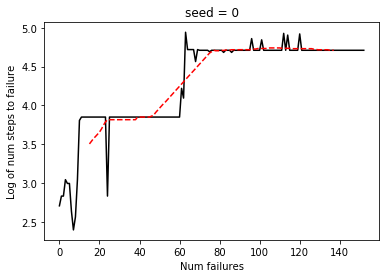

In [176]:
main()